In [1]:
import os
import csv
import glob
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

I0000 00:00:1705437294.613854 3594854 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705437294.652058 3594987 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 530.30.02), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2


In [3]:
# Data path
media_path = '/home/duong/git/Biomechanics/dataset/patient_2_bouding_box'
# print(os.listdir(media_path))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
lm_list = []
lmhi_list = []

def make_landmark_timestep(results):
    c_lm = []
    for id, lm in enumerate(results.pose_landmarks.landmark):
#        if id==16:
            c_lm.append(lm.x)
            c_lm.append(lm.y)
            c_lm.append(lm.z)
    return c_lm

def draw_landmark_on_image(mp_drawing, results, img):
    # Vẽ các đường nối
    mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    # Vẽ các điểm nút
    for id, lm in enumerate(results.pose_landmarks.landmark):
        h, w, c = img.shape
        #print(id, lm)
        cx, cy = int(lm.x * w), int(lm.y * h)
        cv2.circle(img, (cx, cy), 10, (0, 0, 255), cv2.FILLED)
    return img

In [5]:
def detectPose(image, pose, display=True):
    image = cv2.resize(image, (640, 480))
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        lst = []
        n = 0
        hi = 0
        for id, lm in enumerate(results.pose_landmarks.landmark):
            lst[n] = lst.append([id, lm.x, lm.y])
            n + 1
            h, w, c = image.shape
            if id == 0:
                x0, y0 = int(lm.x * w), int(lm.y * h)
            if id == 9:
                x9, y9 = int(lm.x * w), int(lm.y * h)
            if id == 10:
                x10, y10 = int(lm.x * w), int(lm.y * h)
                h0910 = (((x0-(x9+x10)/2) ** 2 + (y0-(y9+y10)/2) ** 2) ** 0.5)  # Khoảng cách giữa trung điểm miệng đến đỉnh mũi
                h6 = h0910 * 3.236  # Khoảng cách từ mũi đến đường chân tóc = khoảng cách giữa trung điểm miệng đến đỉnh mũi x 9
            if id == 11:
                x11, y11 = int(lm.x * w), int(lm.y * h)
            if id == 12:
                x12, y12 = int(lm.x * w), int(lm.y * h)
                xh5 = ((x11 + x12) / 2) - x0
                yh5 = ((y11 + y12) / 2) - y0
                h5 = (xh5 ** 2 + yh5 ** 2) ** 0.5   # Khoảng cách giữa trung điểm vai đến đỉnh mũi
            if id == 23:
                x23, y23 = int(lm.x * w), int(lm.y * h)
            if id == 24:
                x24, y24 = int(lm.x * w), int(lm.y * h)
                # h1 = (11+12,23+24)
                xh1 = (x23 + x24 - x11 - x12) / 2
                yh1 = (y23 + y24 - y11 - y12) / 2
                h1 = (xh1 ** 2 + yh1 ** 2) ** 0.5   # Khoảng cách giữa trung điểm vai đến trung điểm hông
            if id == 26:
                x26, y26 = int(lm.x * w), int(lm.y * h)
                # h2 = (24,26)
                xh2 = (x26 - x24)
                yh2 = (y26 - y24)
                h2 = (xh2 ** 2 + yh2 ** 2) ** 0.5   # Độ dài đùi
            if id == 28:
                x28, y28 = int(lm.x * w), int(lm.y * h)
                # h3 = (26,28)
                xh3 = (x28 - x26)
                yh3 = (y28 - y26)
                h3 = (xh3 ** 2 + yh3 ** 2) ** 0.5   # Độ dài bắp chân
            if id == 30:
                x30, y30 = int(lm.x * w), int(lm.y * h)
            if id == 32:
                x32, y32 = int(lm.x * w), int(lm.y * h)
                # h4 = (28,30+32)
                # đt đi qua 30 và 32 có phương trình ax + by + c = 0
                a = y30 - y32
                b = x32 - x30
                c = -x30 * (y30 - y32) - y30 * (x32 - x30)
                h4 = math.fabs(a * x28 + b * y28 + c) / ((a ** 2 + b ** 2) ** 0.5)   # Khoảng cách từ cổ chân đến bàn chân
                # tính chiều cao

                hb = h5 + h1 + h2 + h3 + h4
                hi = round(hb/math.e, 3)
                # print(hi)
                lmhi_list.append([h5,h1,h2,h3,h4,hi])
                # print([hi,h,w])
            # Ghi nhận thông số khung xương
            lm = make_landmark_timestep(results)
            lm_list.append(lm)

            # Vẽ khung xương lên ảnh
            image = draw_landmark_on_image(mp_drawing, results, image)
            cv2.putText(image, "Height: ", (40, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), thickness=2)
            cv2.putText(image, str(hi), (200, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), thickness=2)
                
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        # mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks    

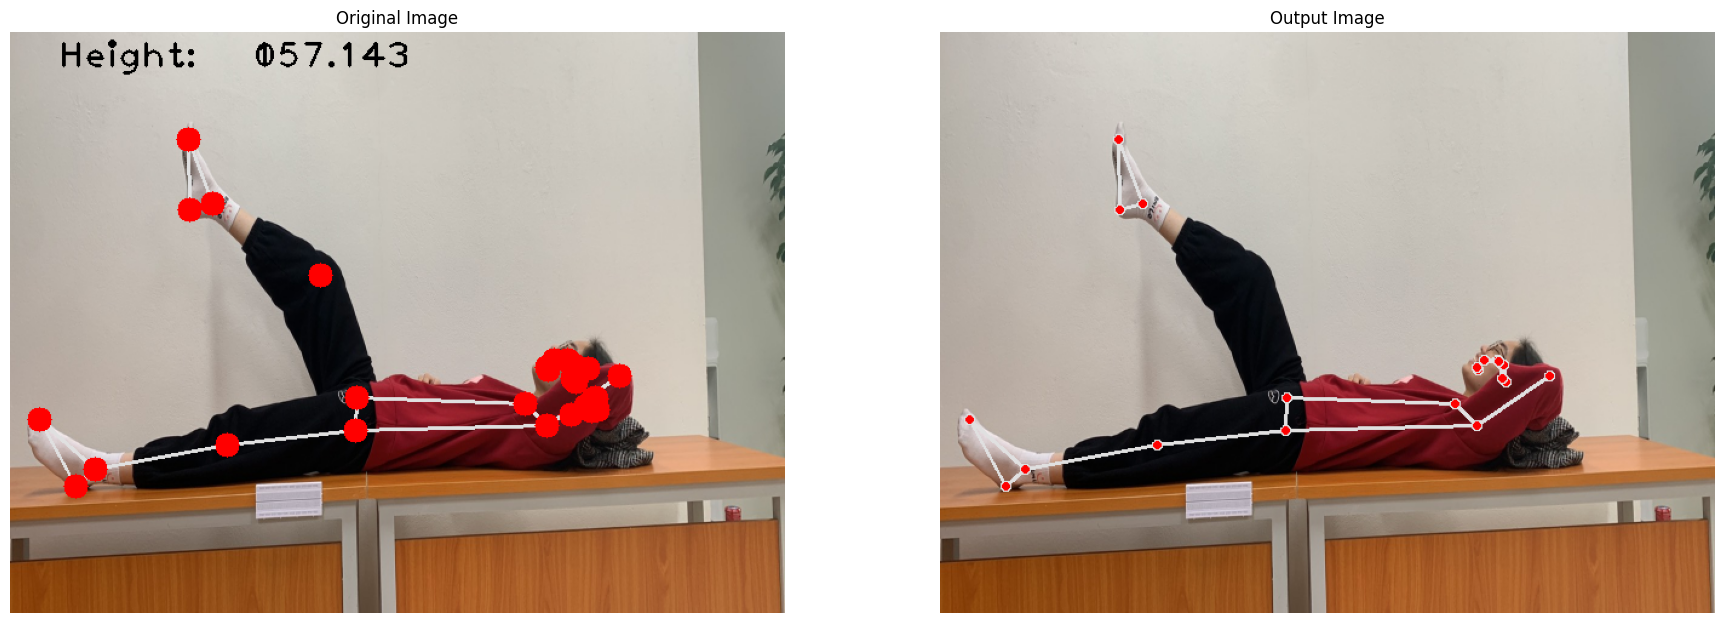

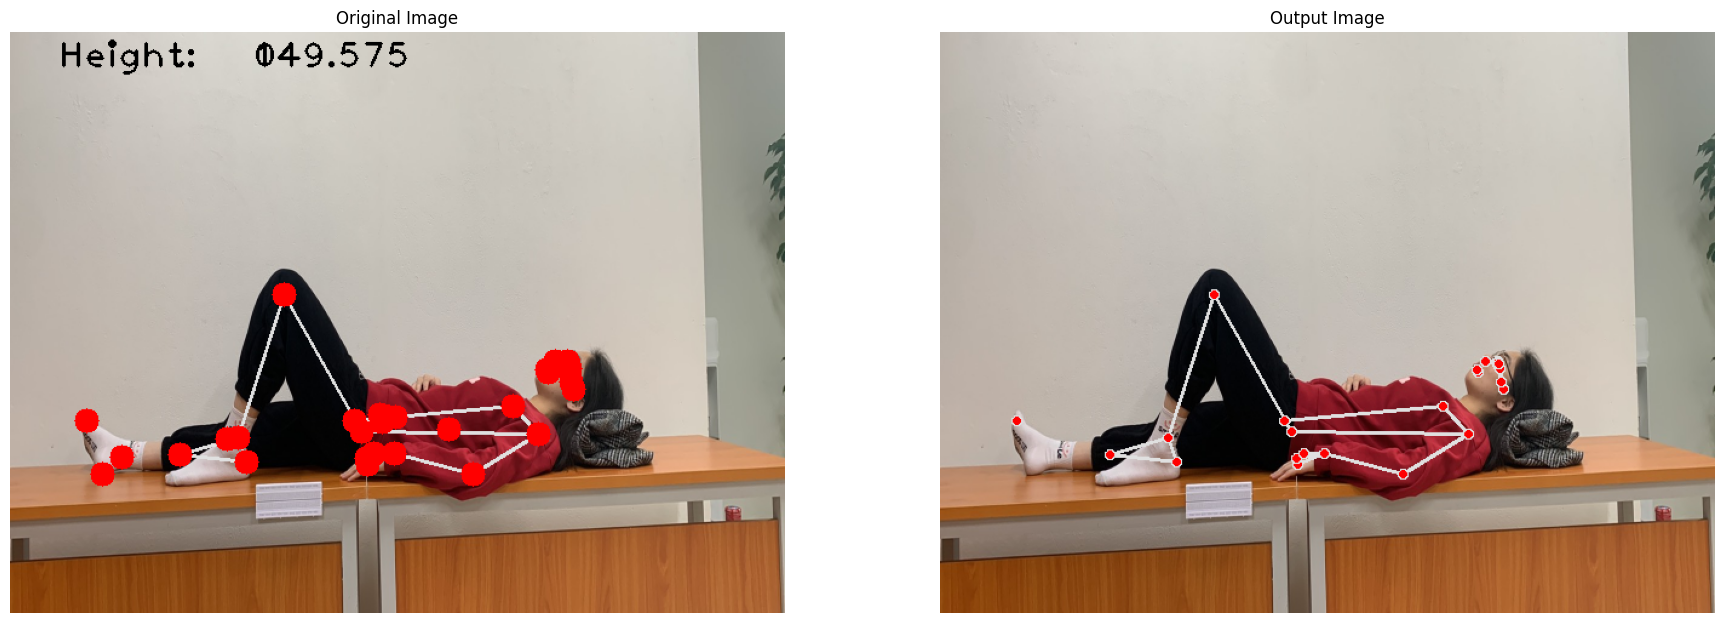

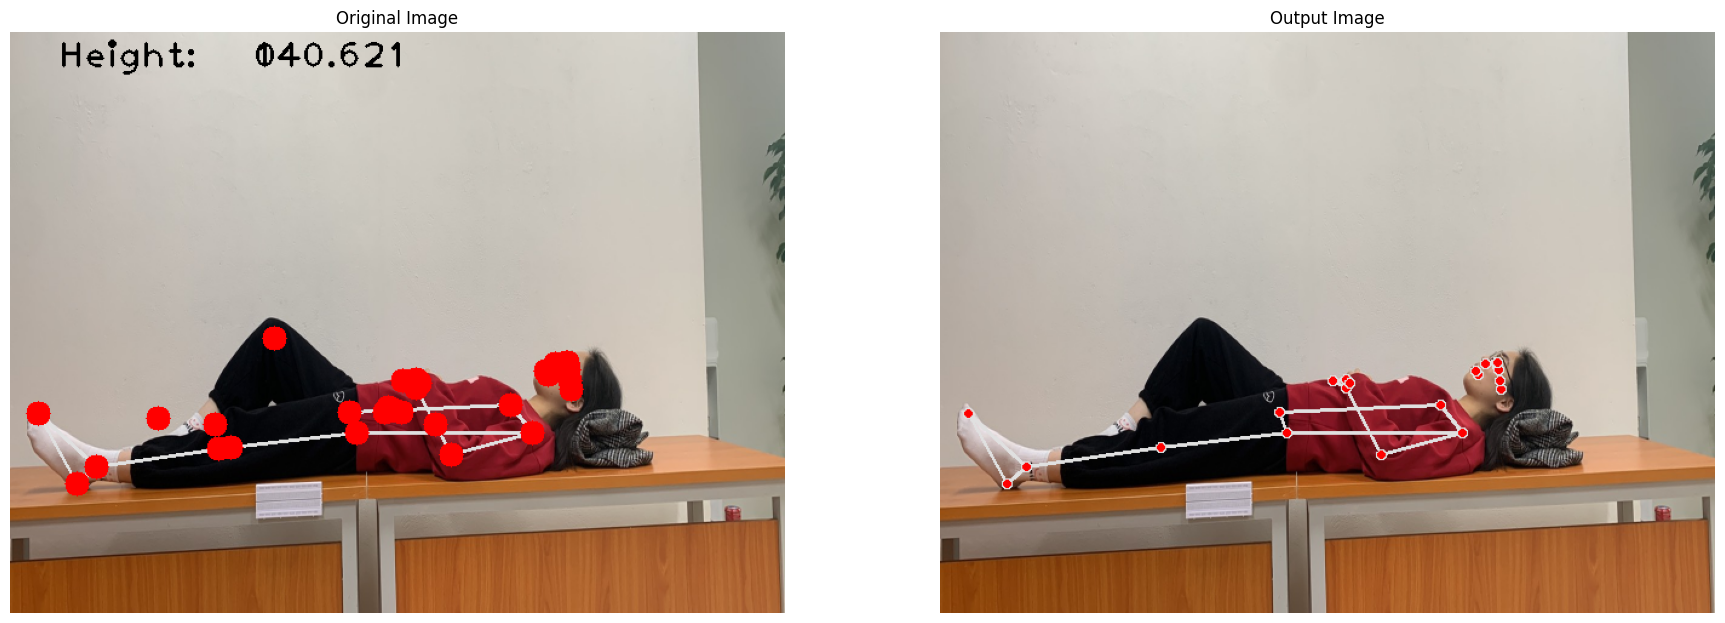

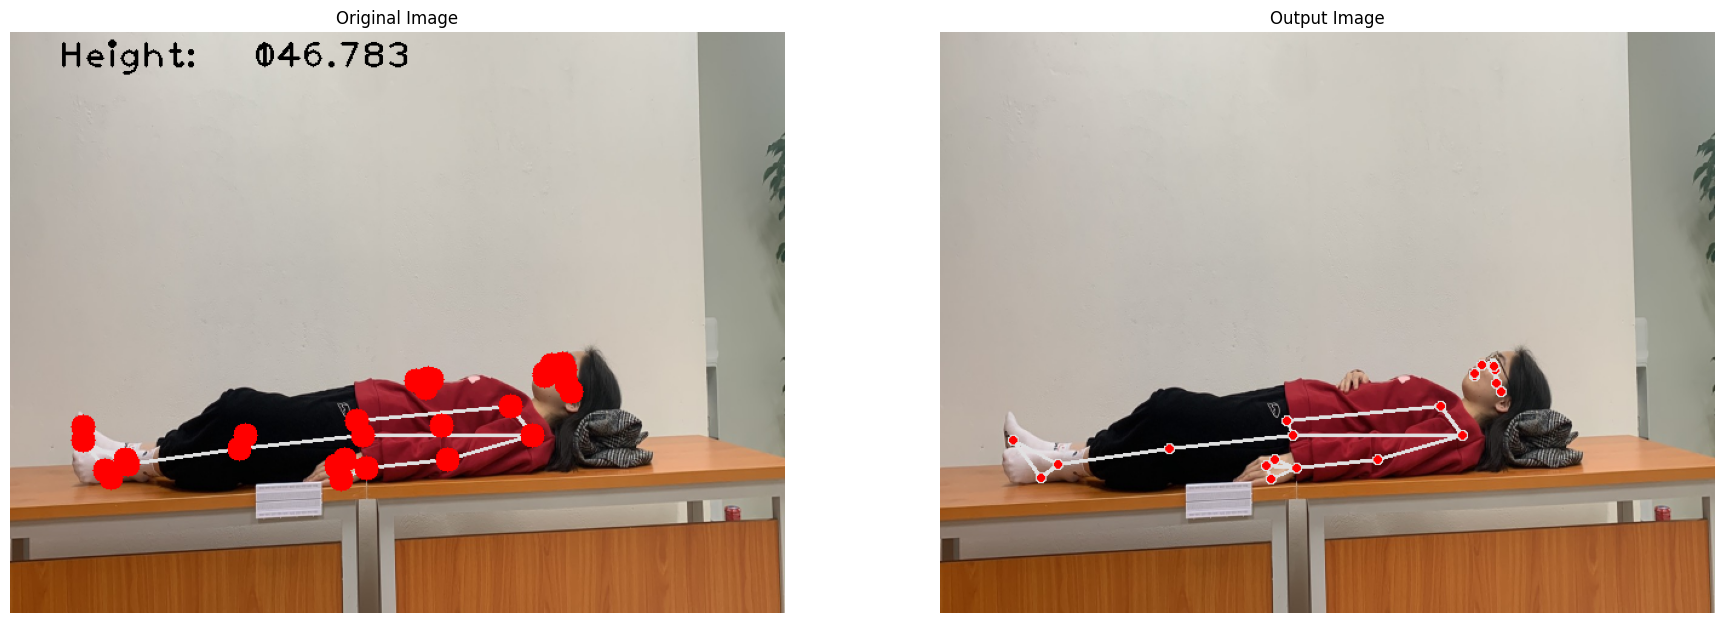

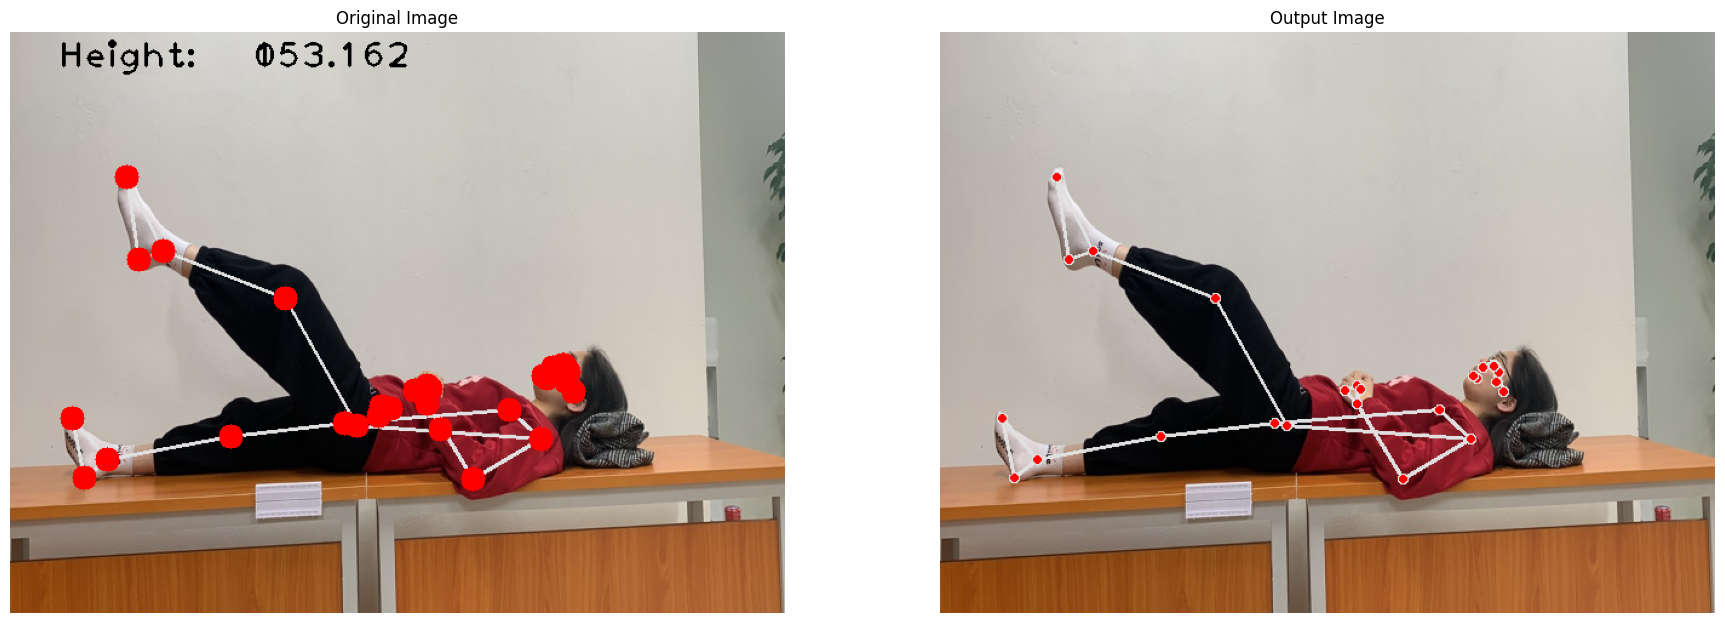

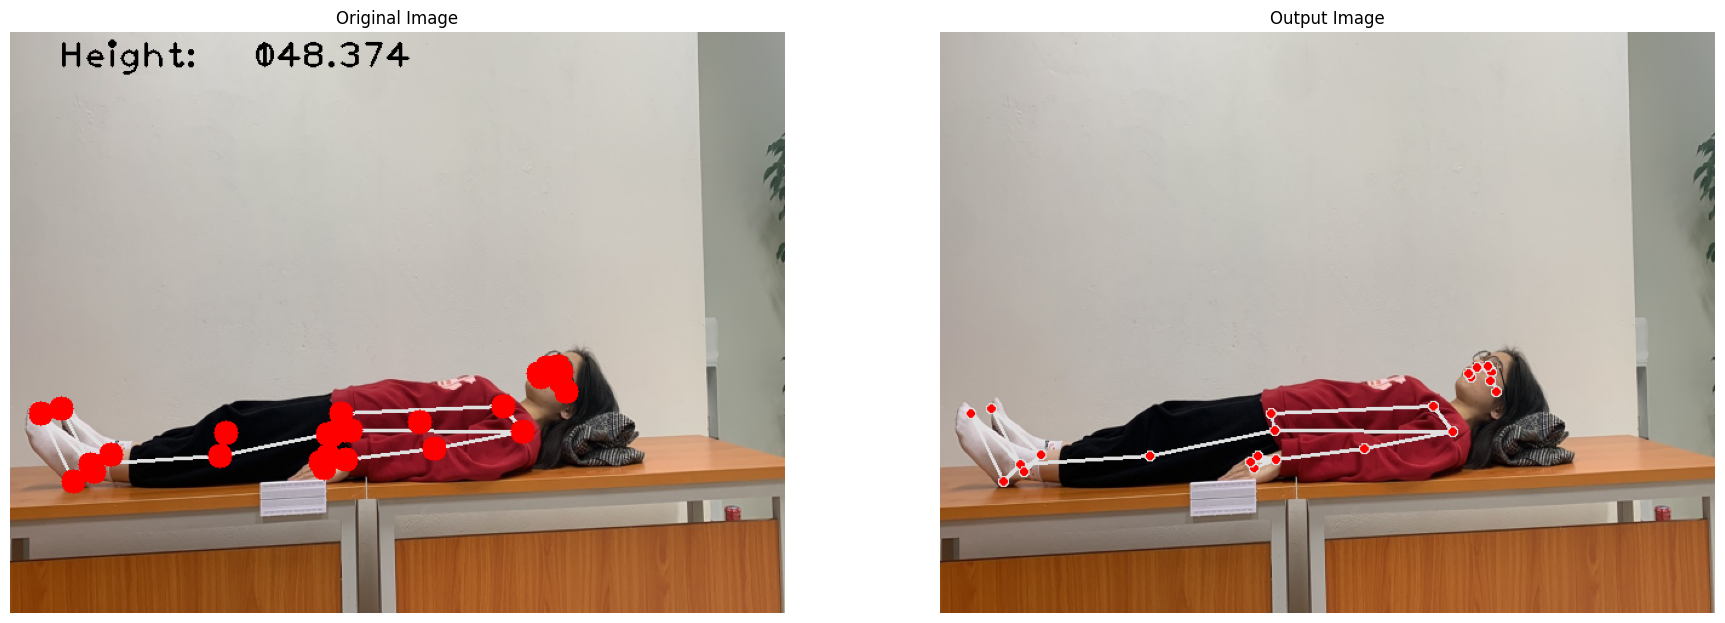

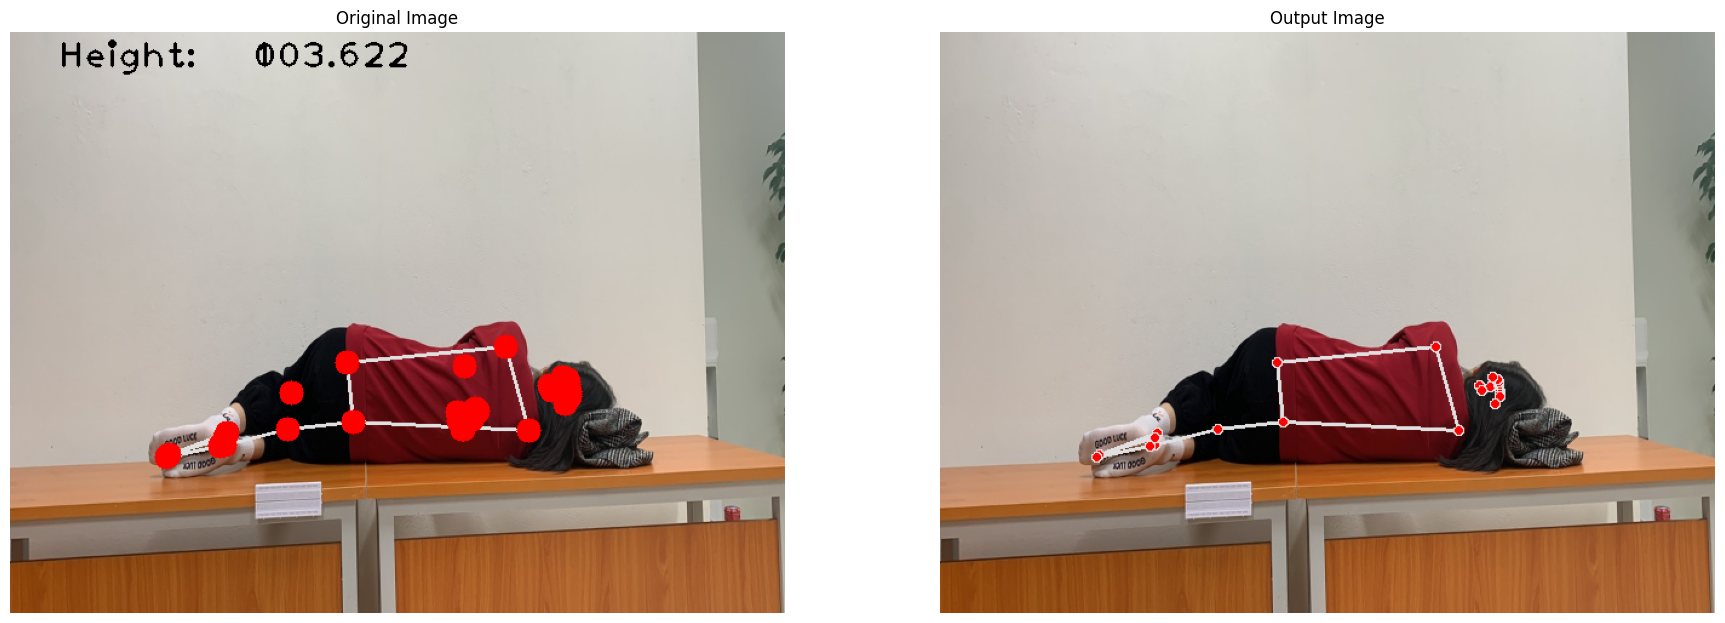

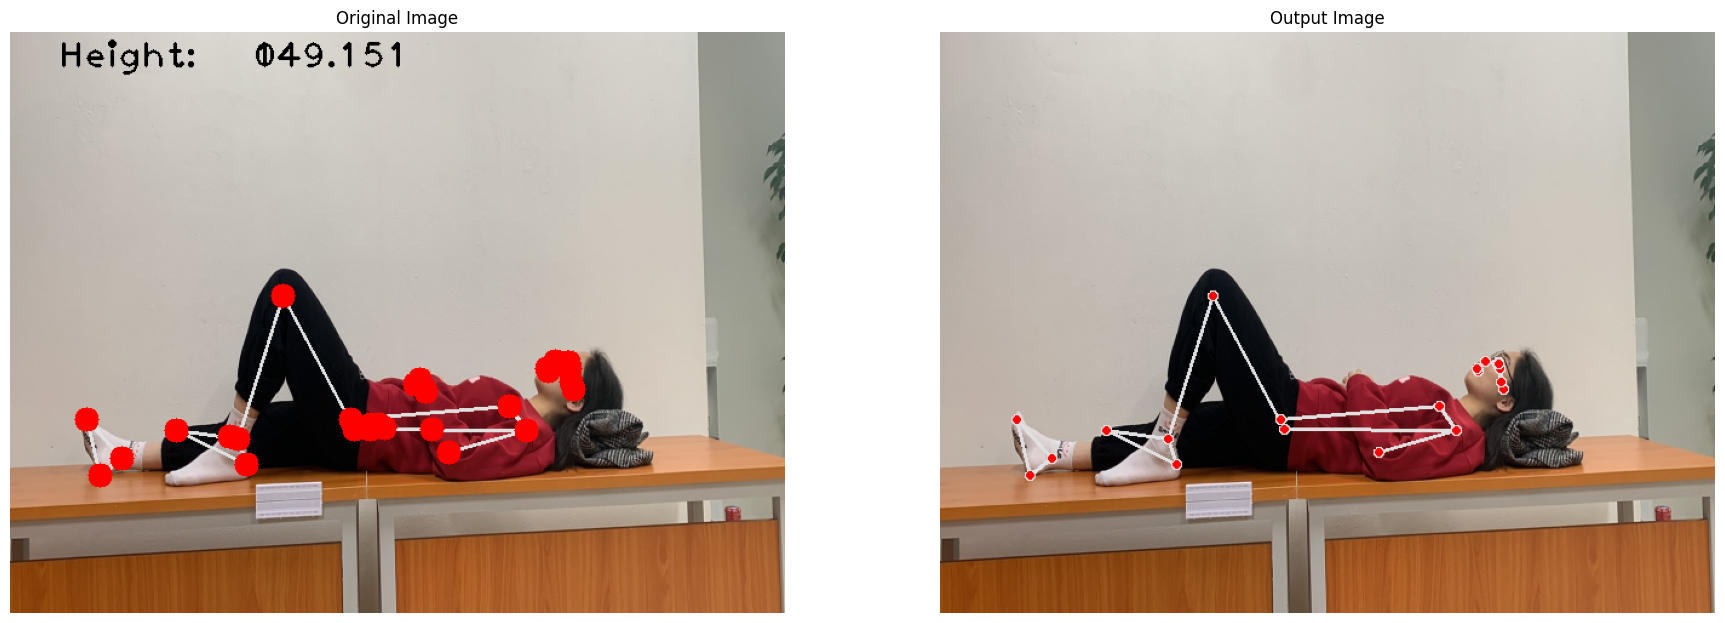

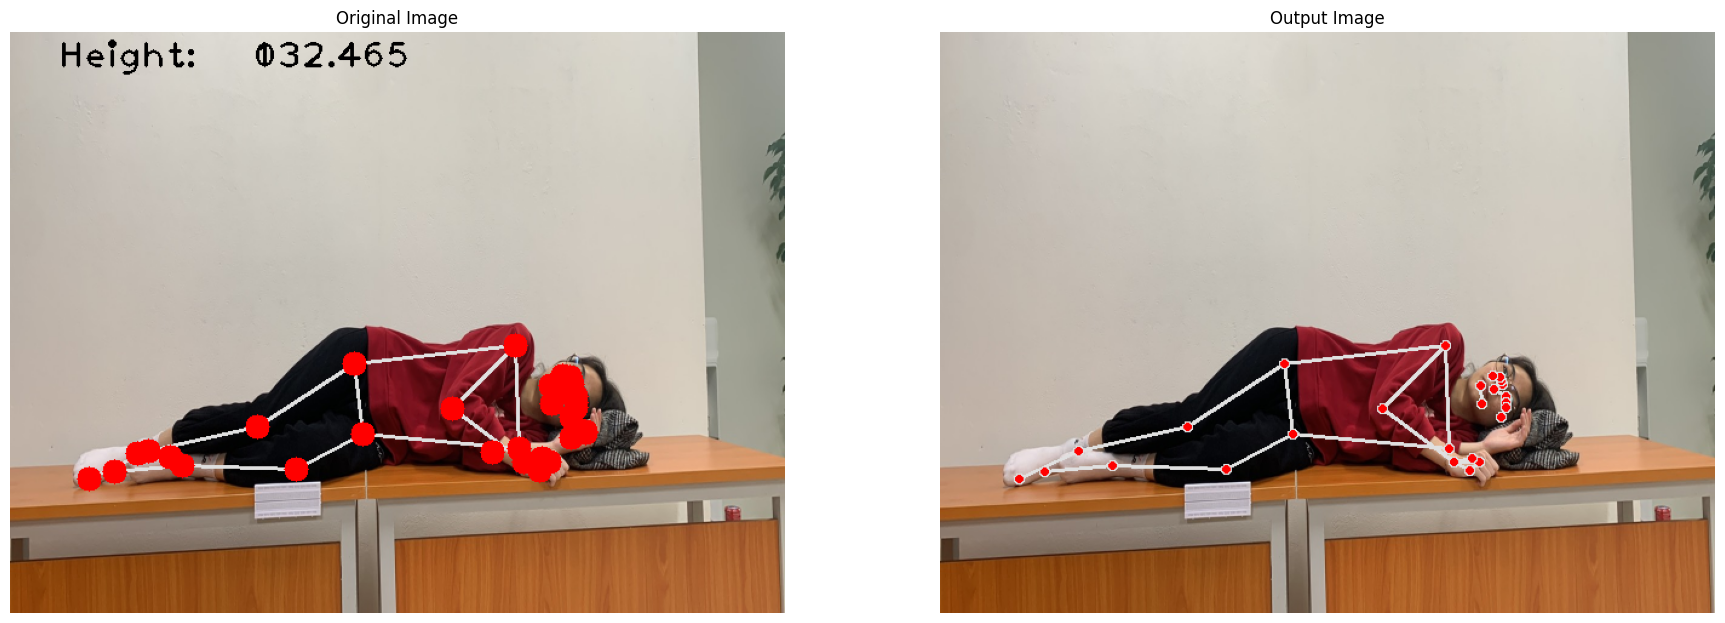

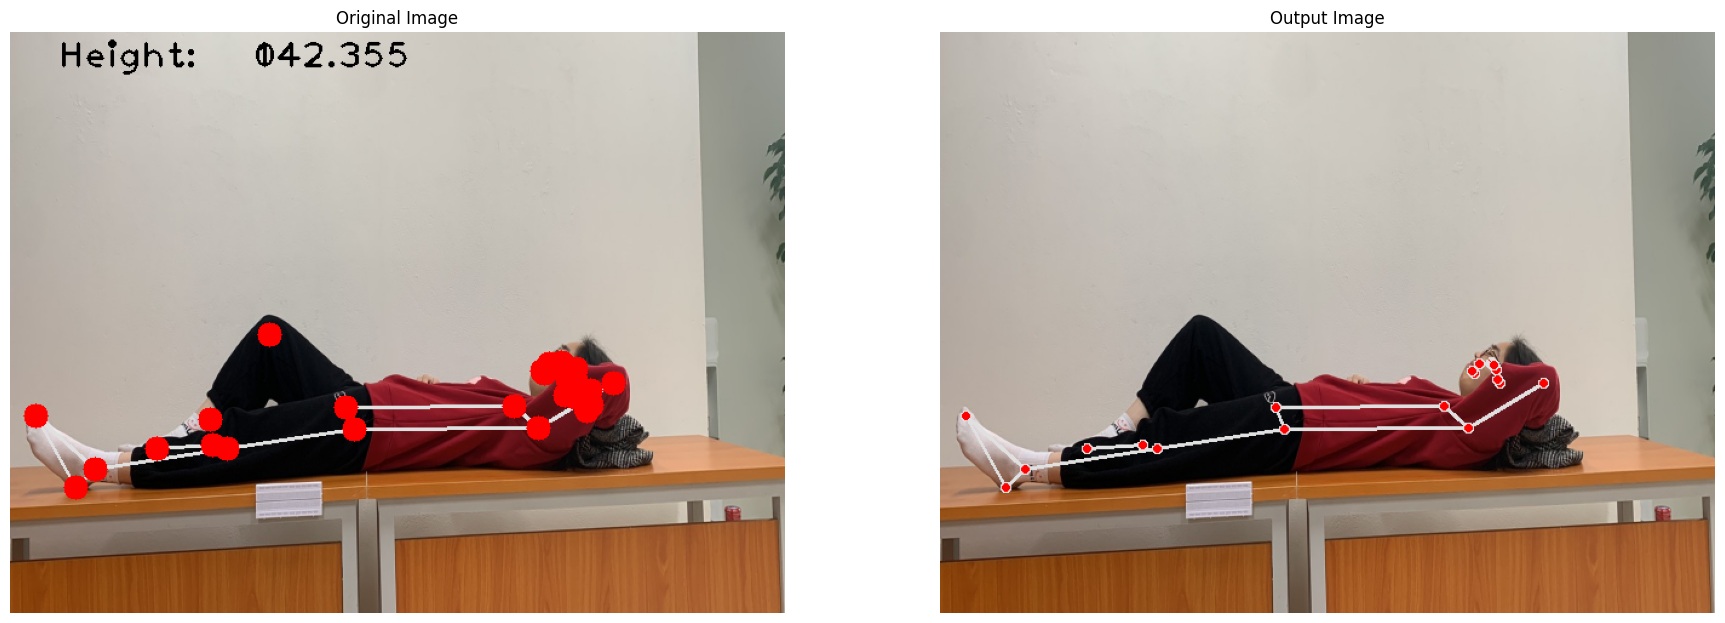

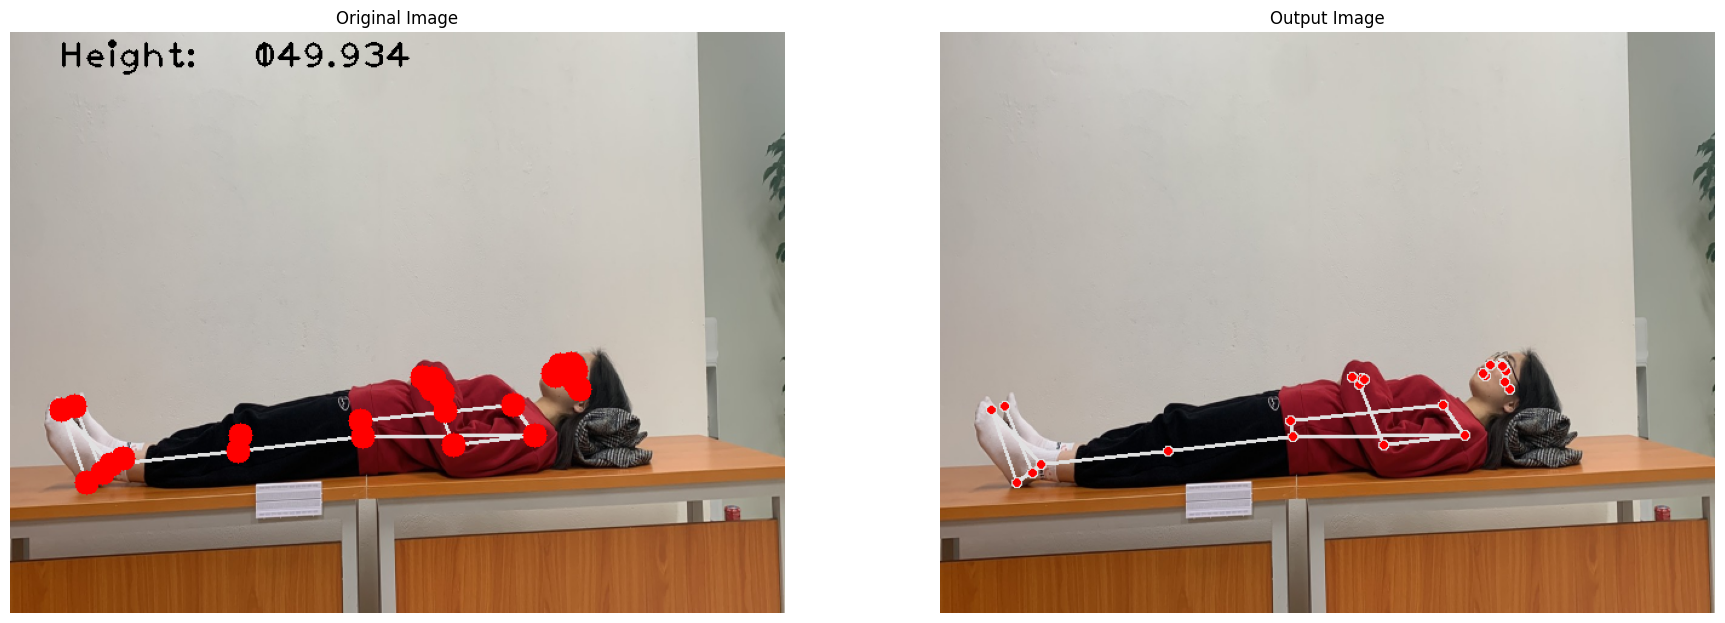

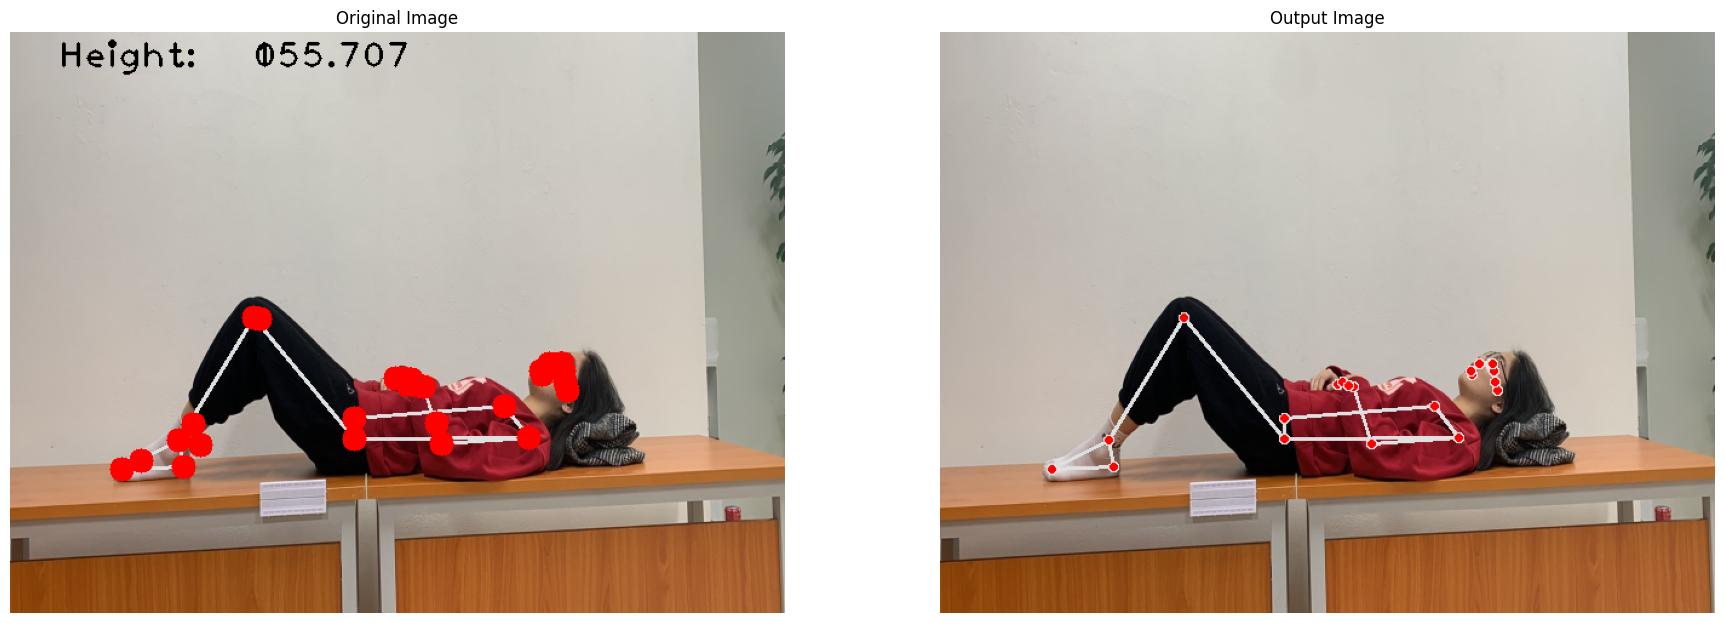

In [6]:
# Lấy danh sách đường dẫn đầy đủ đến các tệp hình ảnh trong thư mục media
image_paths = [os.path.join(media_path, file) for file in os.listdir(media_path)
               if os.path.isfile(os.path.join(media_path, file))
               and file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Loop qua từng đường dẫn ảnh và áp dụng detectPose() lên mỗi ảnh
for img_path in image_paths:
    # Đọc ảnh từ đường dẫn
    image = cv2.imread(img_path)
    
    # Thực hiện pose detection trên ảnh
    detectPose(image, pose, display=True)  # Set display to True để hiển thị ảnh và landmarks